## A typical RAG workflow

Vector databases come in handy in building RAG applications, which is a technique that combines the strengths of large language models (LLMs) with external knowledge sources.

%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

%pip install --quiet "langchain[groq]"

%pip install -qU langchain-chroma

%pip install -qU langchain-openai

%pip install -qU langchain-huggingface

In [1]:
import langgraph
from langgraph.prebuilt import ToolNode

In [1]:
import sys
import os, getpass
from openai import OpenAI
from IPython.display import Image
from pprint import pprint
from dotenv import load_dotenv, find_dotenv
from tqdm import tqdm
import bs4

from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core import documents
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_chroma import Chroma
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings


# Add the project root directory to Python path
project_root = os.path.dirname(os.path.abspath(''))
if project_root not in sys.path:
    sys.path.append(project_root)

from utils import set_api_key


load_dotenv(find_dotenv())  

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
GROQ_API_KEY = set_api_key('GROQ_API_KEY')
OPENAI_API_KEY = set_api_key('OPENAI_API_KEY')


# Embeddings for encoding inputs
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Vector store to persist embeddings
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

USER_AGENT environment variable not set, consider setting it to identify your requests.


API key found in .env file for GROQ_API_KEY
API key found in .env file for OPENAI_API_KEY


d:\AI Projects\AI agent using LangGraph\AI-agent-using-langGraph\ai-agent-langgraph-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# LLM for text generation
#llm = init_chat_model("deepseek-chat", model_provider="deepseek")


# LLM for text generation
llm = init_chat_model("llama3-8b-8192", model_provider="groq")

#llm = init_chat_model("gemini-2.5-flash", model_provider="google_vertexai")

In [6]:
LANGSMITH_TRACING="true"
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"

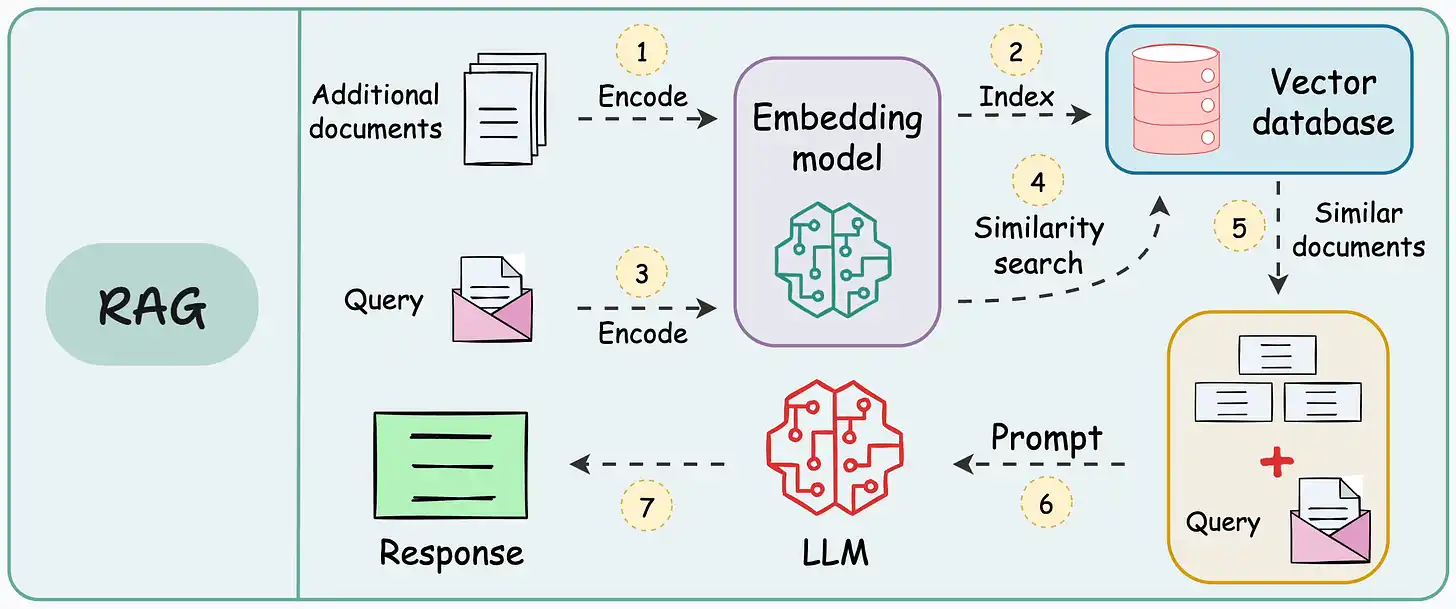

In [7]:
Image(filename='rag.gif', width = 600, height=400)

- Retrieval: Accessing and retrieving information from a knowledge source, such as a database or memory.

- Augmented: Enhancing or enriching something, in this case, the text generation process, with additional information or context.

- Generation: The process of creating or producing something, in this context, generating text or language.

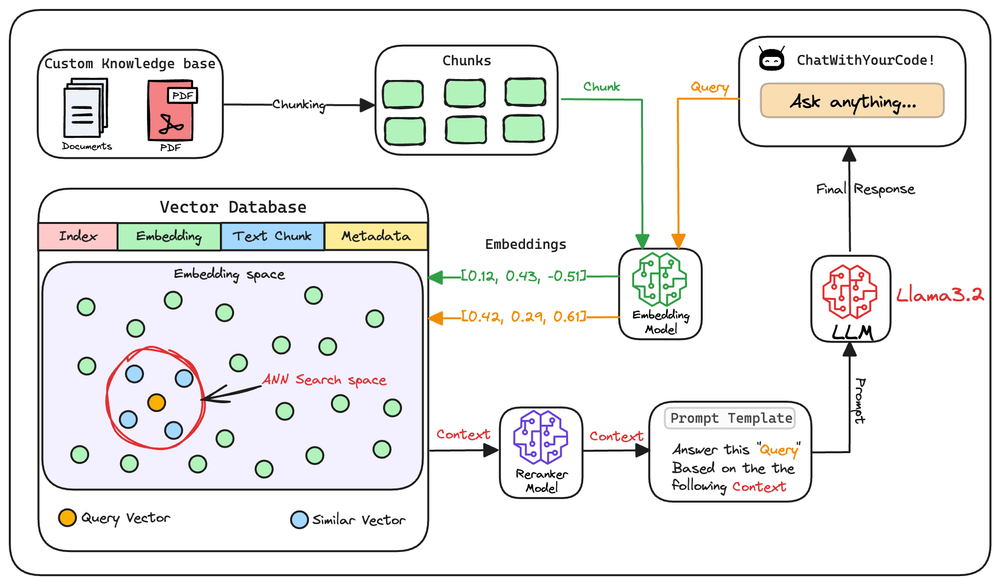

In [8]:
Image(filename='rag_workflow.png', width = 700, height=500)

### Step 1 - Load documents (pdf, html webpage, csv, excel)

In [9]:
# we get the content we need from the webpage
bs4_strainer = bs4.SoupStrainer(class_ = ('post-title', 'post-header', 'post-content' ))

# Create a document loader for the webpage, put the crawler defined above
doc_loader = WebBaseLoader(
    web_paths = ("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer}
)

# build docs
docs = doc_loader.load()
assert len(docs) == 1
print(f"Total Characters: {len(docs[0].page_content)}")


Total Characters: 43047


In [10]:
docs[0].page_content[:500]

'\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn'

### Step 2 - Create chunks

We start with some additional knowledge base aka documents, webpages, blogs, code bases that weren't included/seen during the training.

Since, the knowledge base could be very large in size, it is important to ensure that the text fits the input size of the embedding model. 

So an ideal first step is to break down the text into chunks before embedding and storing it in the vector database.

Note: If we don't chunk the document, the entire document will have a single embedding, which won't be of any practical use to retrieve relevant context.

 We can go two ways with this:
 1. Use the OpenAI API to first create the tokens out of our documents, and then produce text embeddings using an OPENAI tiktoken model.
 2. We can directly use sentence transformer to create embeddings of the documents.

We will do both of them 

In [11]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index = True,
)

all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} chunks of text")

Split blog post into 62 chunks of text


### Step 3 - Storing documents
We need to index our 62 text chunks so that we can search over them at runtime.

In [12]:
document_ids = vector_store.add_documents(all_splits)

In [13]:
print(document_ids[:3])

['b01499a6-d32c-472c-b60e-f823995bb33b', '45b7f346-e93e-4841-8a47-da7a4174f26a', '58b22ae0-44f2-444b-b82b-3d9ab22b6284']


### Step 4 - Retrieval and Generation

In [14]:
prompt = hub.pull("rlm/rag-prompt")
example_messages = prompt.invoke(
    {
        "context": "(context goes here)", "question": "(question goes here)"
    }
).to_messages()
assert len(example_messages) == 1

In [15]:
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


#### Building an application with LangGraph

In [16]:
class State(TypedDict):
    question: str
    context: List[documents.Document]
    answer: str

In [17]:
def retrieval(state:State):
    retrieved_docs = vector_store.similarity_search(state['question'])
    return {"context": retrieved_docs}

In [18]:
def generate(state:State):
    docs_content = "\n\n".join(doc.page_content for doc in state['context'])
    messages = prompt.invoke({"question":state["question"], "context":docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [19]:
graph = StateGraph(State)
graph_builder = graph.add_sequence((retrieval, generate))
graph_builder.add_edge(START, "retrieval")
app = graph_builder.compile()

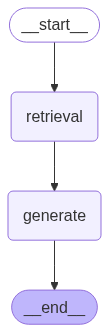

In [20]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
"""
result = app.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")
"""

'\nresult = app.invoke({"question": "What is Task Decomposition?"})\n\nprint(f"Context: {result[\'context\']}\n\n")\nprint(f"Answer: {result[\'answer\']}")\n'

In [22]:
for step in app.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieval': {'context': [Document(id='f9a4b0ac-b078-4907-a227-742072f84073', metadata={'section': 'beginning', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the plannin

In [23]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(tqdm(all_splits)):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

100%|██████████| 62/62 [00:00<?, ?it/s]


{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [24]:
new_documents = vector_store.add_documents(all_splits)

In [25]:
new_documents[:3]

['c3b7fa34-0149-45ee-8a8b-6e53180703ef',
 '973a3835-0a36-4f22-b5a6-2aa14d641482',
 '3895d409-0739-48ab-b0e0-7788693aa90e']

### Creating conversational method and multi step retrieval in RAG

In [26]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [27]:
from langchain_core.tools import tool

In [28]:
@tool(response_format="content_and_artifact")
def retrieve(query:str):
    """Retrieve relevant documents from the vector store based on the query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
         for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

A node that fields the user input, either generating a query for the retriever or responding directly

A node for the retriever tool that executes the retrieval step;

A node that generates the final response using the retrieved context.

In [29]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

In [30]:
# Step 1 - Generate a SystemMessage that may include a tool-call to be sent
def query_or_respond(state: MessagesState):
    """Generate tool call or simply respond with a message"""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

# Step 2 - Execute the retrieval
tools = ToolNode([retrieve])

# Step 3 - Generate a response using the retrieved content
def generate(state:MessagesState):
    """Generate answer"""
    recent_tool_messages  = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break

    tool_message = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_message)
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f" {docs_content}"
    )

    conversation_messages = [message for message in state["messages"] if message.type in ("human", "system") 
                             or (message.type == "ai" and not message.tool_calls) ]
    
    prompt = [SystemMessage(system_message)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}


In [31]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

In [32]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges("query_or_respond", tools_condition, {END:END, "tools":"tools"},)

graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

app = graph_builder.compile()


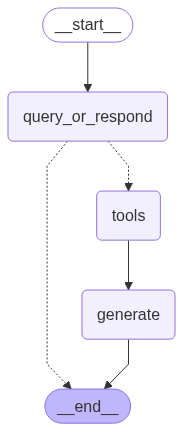

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
input_message = "What are autonomous agents?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are autonomous agents?
================================== Ai Message ==================================
Tool Calls:
  retrieve (3dt8nnyas)
 Call ID: 3dt8nnyas
  Args:
    query: autonomous agents
================================= Tool Message =================================
Name: retrieve

Source: {'start_index': 8, 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous 

In [35]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = graph_builder.compile(checkpointer=memory)

#specify thread id
config = {"configurable": {"thread_id": "xyz123"}}


In [36]:
input_message = "What are autonomous agents?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values", config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are autonomous agents?


BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'define' which was not in request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_call": {\n        "id": "pending",\n        "type": "function",\n        "function": {\n            "name": "define"\n        },\n        "parameters": {\n            "term": "autonomous agents"\n        }\n    }\n}\n</tool-use>'}}

In [ ]:
input_message = "Can you explain more about it?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values", config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you explain more about it?
================================== Ai Message ==================================

Autonomous agents are typically software-based systems that operate independently, making decisions and taking actions based on their programming and the data they receive. They can be designed to perform a wide range of tasks, from simple ones like controlling a robot arm to more complex ones like managing a supply chain or making financial trades.

In the context of large language models (LLMs), autonomous agents can be thought of as AI systems that use the LLM as their core controller. The LLM provides the intelligence and decision-making abilities for the agent, allowing it to learn from its experiences and adapt to new situations.

Some key characteristics of autonomous agents include:

1. Autonomy: Autonomous agents make their own decisions and take actions independently, without direct h

In [ ]:
input_message = "Hi"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values", config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hi!


In [ ]:
input_message = "Hi, how are you?"

for step in app.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values", config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, how are you?
================================== Ai Message ==================================

I'm doing well, thanks! I'm a large language model, so I don't have feelings like humans do, but I'm always happy to chat with you and help with any questions or topics you'd like to discuss. How about you?


#### Building Agentic RAG

In [37]:
from langgraph.prebuilt import create_react_agent

In [39]:
agent = create_react_agent(model=llm, tools=[retrieve], checkpointer=memory)

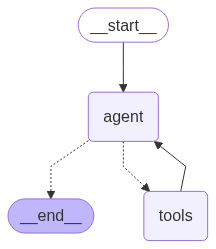

In [40]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [41]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

The standard method for Task Decomposition is the Divide and Conquer approach. This method involves breaking down a complex task into smaller, more manageable subtasks, which are then solved individually and combined to form the final solution.

In this approach, the task is decomposed into smaller subtasks by identifying the key components or elements that need to be addressed. Each subtask is then solved independently, and the solutions are combined to form the final solution.

Here's a step-by-step process for using the Divide and Conquer approach:

1. Identify the task: Clearly define the task that needs to be decomposed.
2. Identify the key components: Break down the task into smaller components or ele

In [32]:
import tiktoken

question = 'What kind of movies do you like?'
document = 'I like action movies.'

In [33]:
def get_tokens_from_text(text:str, encoding:str ) -> list:
    encoding_model = tiktoken.get_encoding(encoding)
    tokens = encoding_model.encode(text)
    print(f'Number of tokens: {len(tokens)}')
    print(f'Tokens: {tokens}')
    

In [34]:
get_tokens_from_text(question, "cl100k_base")

Number of tokens: 8
Tokens: [3923, 3169, 315, 9698, 656, 499, 1093, 30]


In [35]:
from sentence_transformers import SentenceTransformer
model_name = 'all-MiniLM-L6-v2'
encode_model = SentenceTransformer(model_name)

In [36]:
# In this case we are directly using the SentenceTransformer which creates an indexing model with 768 dimensions and can be stored in a vector db
def get_tokens_from_sentence_transformer(text, model):
    tokens = model.encode(text)
    print(f'Number of tokens: {len(tokens)}')
    #print(f'Tokens: {tokens}')

In [37]:
get_tokens_from_sentence_transformer(question, encode_model)

Number of tokens: 384


In [38]:
from langchain_pymupdf4llm import PyMuPDF4LLMLoader
from langchain_community.document_loaders import PyPDFLoader
from typing import List, Iterator
import os

def batch_load_pdf(file_path, batch_size):
    loader = PyMuPDF4LLMLoader(file_path)
    pages = list(loader.lazy_load())[2]

    total_pages = len(pages)

    for i in range(0, total_pages, batch_size):
        yield pages[i:i + batch_size]

In [39]:
# Process pdf in batches, split the text into chunks and load in vectorstore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
import chromadb.utils.embedding_functions as embedding_functions
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

def process_pdf_in_batches(file_path,
                           embedding_model,
                           batch_size,
                           chunk_size,
                           chunk_overlap):
        """
    Process PDF in batches, split documents, and store embeddings
    
    Args:
        file_path (str): Path to PDF
        embedding_model: Embedding model to use
        batch_size (int): Number of pages per batch
        chunk_size (int): Size of text chunks
        chunk_overlap (int): Overlap between chunks
    """
        text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
        
        vectorstore = Chroma(embedding_function= embedding_model)

        for batch_idx, page_batch in enumerate(batch_load_pdf(file_path, batch_size=100)):
                try:
                        batch_splits = text_splitter.split_documents(page_batch)
                        vectorstore.add_documents(batch_splits)
                        print(f"Processed batch {batch_idx + 1} with {len(page_batch)} pages")
                except Exception as e:
                        print(f"Error processing batch {batch_idx + 1}: {e}")
        return vectorstore

In [40]:
file_path = 'D:\AI Projects\AI agent using LangGraph\AI-agent-using-langGraph\income-tax-act-1961-amended-by-finance-no.-2-act-2024.pdf'

In [41]:
process_pdf_in_batches(file_path=file_path,
                       embedding_model= HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"),
                       batch_size=100,
                       chunk_size=1000,
                       chunk_overlap=200)

C:\Users\chaya\AppData\Local\Temp\ipykernel_56540\415994133.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model= HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"),
C:\Users\chaya\AppData\Local\Temp\ipykernel_56540\1879842459.py:28: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(embedding_function= embedd

KeyboardInterrupt: 

In [ ]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:

# Split

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [ ]:


sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name='distilbert-base-nli-stsb-mean-tokens'
)


In [ ]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectorstore = Chroma(collection_name='first_rag_collection', embedding_function=embeddings)

C:\Users\chaya\AppData\Local\Temp\ipykernel_23096\169803839.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
d:\AI Projects\AI agent using LangGraph\AI-agent-using-langGraph\ai-agent-langgraph-env\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\chaya\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more

In [ ]:
vectorstore.add_documents(splits)

['c2ecb344-94c4-4774-8a3d-dca9c91d3a76',
 '1872a38d-fb4e-4ea4-b96d-186e2296857f',
 '41a084c0-9d30-4c4e-a882-8cba5a2d5650',
 '9fb4a6c7-9f31-429d-a1bf-458732d7e21a',
 '86b71b52-b33a-43f1-b689-a4cf49bd4720',
 'a95636af-fde3-46bc-8c8f-26b9357ef642',
 '91ce46e7-4f3b-400a-b90f-e6449133d54c',
 '550ef468-ffe7-44a3-9a9f-c13ff159fe68',
 'b77edeab-0794-46e4-8960-c6d677ab912b',
 'd7294723-1243-40ae-81a5-15ef3239e15b',
 '2f830ad9-7603-44b5-b87f-8db5ae3258d7',
 '80495e83-81f4-4342-a8fa-488ad5a574e4',
 '8c7c658e-9a22-4446-bfe1-1883d8c2337f',
 '2e82ceb7-ea6a-4562-bc63-874ccc1f0849',
 'c087d5e3-0721-4d72-86bb-2dda7cb7750f',
 '41ef3ccf-b00b-4543-b3fe-3854ea768771',
 '5fdee338-5261-4687-a623-15a6f6479d4b',
 '9f23bc0e-1c0a-437b-813e-796dd87f263b',
 'bc31b6d5-644b-4a43-9f4c-7fb69759a9fb',
 '87b7d3f9-1788-493f-8edf-f8e8070db209',
 '946cba34-fa56-40c7-bd3f-348204715963',
 '28d06cb7-8913-41f2-949c-8ddf3aecd6aa',
 'da82a177-1fbc-4211-963c-e2b0849f9627',
 '3bf4ee73-1c00-40e7-b984-9eea75976834',
 'f7a6a45f-6d65-

TypeError: SelfQueryRetriever.from_llm() missing 2 required positional arguments: 'document_contents' and 'metadata_field_info'

: 